In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import pandas as pd
import os

tqdm.pandas()

In [2]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

In [3]:
# Raw data 
bldg_recent = gpd.read_file(os.path.join(OAK_FP, 'permits', 'bldg_recent.geojson'))
bldg_active = gpd.read_file(os.path.join(OAK_FP, 'permits', 'bldg_active.geojson'))
bldg_expired = gpd.read_file(os.path.join(OAK_FP, 'permits', 'bldg_expired.geojson'))

bldg_active['OBJECTID'] = bldg_active['OBJECTID'].astype(str).apply(lambda x: f'A_{x}')
bldg_recent['OBJECTID'] = bldg_recent['OBJECTID'].astype(str).apply(lambda x: f'R_{x}')
bldg_expired['OBJECTID'] = bldg_expired['OBJECTID'].astype(str).apply(lambda x: f'E_{x}')

cols = list(bldg_active.columns) + ['permit_status']
permits_raw = gpd.GeoDataFrame(columns=cols)
for i, status in zip([bldg_active, bldg_recent, bldg_expired], ['active', 'recent', 'expired']):
    i['permit_status'] = status
    # Subset
    i = i[i['WORKDESC'].isin(['New Construction', 'Additions/Alterations'])]
    permits_raw = pd.concat([permits_raw, i])
permits_raw = permits_raw.reset_index(drop=True)

permits_raw.crs = "EPSG:4326"
permits_raw['year'] = permits_raw['FOLDERNUM'].apply(lambda x: int(x.split('-')[0]))

In [4]:
parcel_density_permitted = pd.read_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density_permitted.csv'), 
    dtype={'GEOID': str})
CF_area_coverage = gpd.read_file(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'CF_area_coverage'))

In [5]:
# Our current data (just AA+NC permits)
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits.drop_duplicates(inplace=True)

permits_raw.crs = "EPSG:4326"

In [6]:
# SJ Residential parcels
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

In [7]:
sj_parcels = gpd.read_file(os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_parcels.geojson'))

In [8]:
permits_raw['APN'].isna().sum()

197

## Discrepancies in APNs
`OBJECTID` is unique and can be used to merge datasets. Compare original parcel APN, new parcel APN, address and permit geometry (Point). 

In [9]:
merged = pd.merge(
    permits_raw[['OBJECTID', 'APN', 'WORKDESC', 'ADDRESS', 'geometry']], 
    permits[['OBJECTID_left', 'APN_parcel', 'geometry_parcel', 'issue_year']], 
    how='left', left_on='OBJECTID', right_on='OBJECTID_left', validate='one_to_one'
)

We currently have 3,857 AANC permits that do not have matching parcel APNs. Note that only 197 AANC permits have missing APNs originally so this means there is an actual mismatch in the APNs (rather than missing values) for these permits.

In [10]:
(merged['APN'] != merged['APN_parcel']).sum()

3845

In [11]:
mismatched = merged.loc[merged['APN'] != merged['APN_parcel']]

# Add parcel geometry for the original parcel APN
mismatched = pd.merge(
    mismatched, sj_parcels_cbgs[['APN', 'geometry']], on='APN', how='left', validate='many_to_one')
mismatched = mismatched.set_geometry("geometry_x")

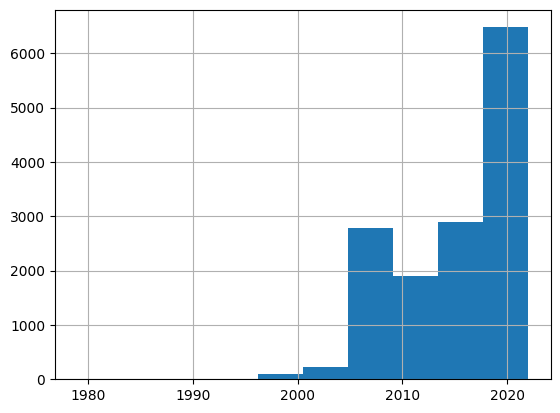

In [12]:
permits['issue_year'].hist()
plt.show()

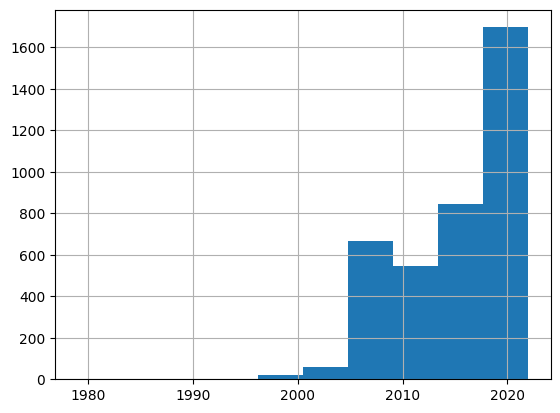

In [13]:
mismatched['issue_year'].hist()
plt.show()

View a specific parcel

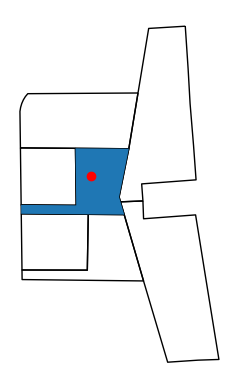

In [28]:
apn = '42949025'
objectid = 'A_5045'
xmin, ymin, xmax, ymax = sj_parcels.loc[sj_parcels['APN'] == apn].total_bounds
sj_parcels_filter = sj_parcels.cx[xmin:xmax, ymin:ymax]

fig, ax = plt.subplots()
sj_parcels_filter.plot(ax=ax, facecolor='none')
sj_parcels.loc[sj_parcels['APN'] == apn].plot(ax=ax)
mismatched.loc[mismatched['OBJECTID'] == objectid].plot(ax=ax, color='red')
ax.axis('off')
plt.show()

How many parcels fall in the residential area

In [14]:
residential_SJ = sj_parcels_cbgs['geometry'].buffer(0).unary_union
mismatched_res = gpd.clip(mismatched, residential_SJ)
print(len(mismatched_res))

594


In [ ]:
# Stopped at cully 2089

In [22]:
idx = np.random.choice(range(len(mismatched_res)), size=20, replace=False)
mismatched_res.iloc[idx]

,OBJECTID,APN,WORKDESC,ADDRESS,geometry_x,OBJECTID_left,APN_parcel,geometry_parcel,geometry_y
1067,R_53451,23046034,New Construction,"321 GRANVILLE CT 2 , SAN JOSE CA 95139",POINT (-121.76849 37.22011),R_53451,70818044,POLYGON ((-121.76848013820833 37.2203196318399...,None
223,A_48702,41414043,Additions/Alterations,"2865 LEIGH AV , SAN JOSE CA 95124-1633",POINT (-121.92166 37.26922),A_48702,44236001,POLYGON ((-121.92186581715715 37.2692997890160...,"POLYGON ((-121.93864 37.26646, -121.93843 37.2..."
1273,E_3265,None,Additions/Alterations,"631 N 21ST ST , SAN JOSE CA 95112-1627",POINT (-121.87946 37.35684),E_3265,24925060,POLYGON ((-121.87927923161405 37.3569929142966...,None
2168,E_19791,46204028,Additions/Alterations,"454 MEADOW DALE CT , SAN JOSE CA 95136-2055",POINT (-121.85191 37.26898),E_19791,46204057,POLYGON ((-121.85164995191819 37.2687930739862...,None
2505,E_28680,43431087,Additions/Alterations,"797 WILLOW GLEN WY , SAN JOSE CA 95125-1870",POINT (-121.88738 37.30419),E_28680,43431091,POLYGON ((-121.88721463185833 37.3042763655276...,None
2255,E_22294,56940088,Additions/Alterations,"1286 BOURET DR 4 , SAN JOSE CA 95118-2618",POINT (-121.88567 37.25734),E_22294,56941C15,POLYGON ((-121.88572698262799 37.2575649330019...,None
283,A_52429,41425001,New Construction,"2061 CULLY PL , SAN JOSE CA 95124",POINT (-121.93349 37.26516),A_52429,41452003,POLYGON ((-121.93333048888977 37.2652178915183...,None
370,A_55679,45525027,New Construction,"2459 NIGHTINGALE DR 2 , SAN JOSE CA 95125",POINT (-121.87670 37.28907),A_55679,45624026,POLYGON ((-121.87659692697113 37.2887892059131...,None
2244,E_22245,56940088,Additions/Alterations,"4771 CAPAY DR 4 , SAN JOSE CA 95118-2585",POINT (-121.88712 37.25825),E_22245,56940C16,POLYGON ((-121.88718250942362 37.2583448379924...,None
254,A_50040,66022065,Additions/Alterations,"3025 BELLWORTH CT , SAN JOSE CA 95135-0000",POINT (-121.77427 37.30518),A_50040,66022104,POLYGON ((-121.77417754347431 37.3049457608058...,None


Look at a random sample of 50

In [29]:
#idx = np.random.choice(range(len(mismatched)), size=50, replace=False)
#mismatched.iloc[idx]

## Unmatched permits and unmatched small buildings

In [15]:
parcel_density_permitted = pd.merge(
    parcel_density_permitted, sj_parcels_cbgs[['APN', 'geometry']],
    how='left', validate='one_to_one')

parcel_density_permitted = gpd.GeoDataFrame(parcel_density_permitted)
parcel_density_permitted.crs = 'EPSG:4326'

In [16]:
# Parcels with small building growth
sbgrowth_parcels = parcel_density_permitted.loc[
    parcel_density_permitted['permitted_change'] +  parcel_density_permitted['unpermitted_change'] > 0]
sbgrowth_permitted = parcel_density_permitted.loc[
    parcel_density_permitted['permitted_change'] > 0]
sbgrowth_permitted_parcels = parcel_density_permitted.loc[
    parcel_density_permitted['permitted_change'] > 0]['APN'].unique()
sbgrowth_unpermitted_parcels = parcel_density_permitted.loc[
    parcel_density_permitted['unpermitted_change'] > 0]['APN'].unique()

print('Number of new small buildings: {}'.format(
    sbgrowth_parcels[['permitted_change', 'unpermitted_change']].sum().sum()))

print('Number of permitted small buildings: {}'.format(sbgrowth_parcels['permitted_change'].sum()))

Number of new small buildings: 1849.0
Number of permitted small buildings: 31.0


In [17]:
#permits.loc[permits['APN_parcel'].isin(sbgrowth_permitted_parcels)].info()

In [18]:
# Buffer CF area
CF_area_coverage_buff = CF_area_coverage.to_crs('EPSG:26910').buffer(0).to_crs('EPSG:4326')

# Permits within CF area coverage
permits_CF_area = gpd.GeoDataFrame(
    permits[['APN_parcel', 'issue_year', 'geometry_permit', 'WORKDESC', 'SUBDESC', 'PERMITVALUE', 
            'SQUAREFOOT', 'DWELLINGUNIT']], 
    geometry='geometry_permit')
permits_CF_area.crs = 'EPSG:4326'
permits_CF_area = gpd.clip(permits_CF_area, CF_area_coverage_buff)

permits_CF_area = permits_CF_area.loc[
    permits_CF_area['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])]
print('Number of permits within CF area: {}'.format(len(permits_CF_area)))

Number of permits within CF area: 425


In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
CF_area_coverage.plot(ax=ax, facecolor='none')
parcel_density_permitted.plot(ax=ax, color='red')
sbgrowth_permitted.loc[~sbgrowth_permitted['APN'].isin(permits_CF_area['APN_parcel'])].buffer(0.0005).plot(
    ax=ax, color='blue')
ax.axis('off')
plt.show()

## Unmatched permits

In [19]:
# Unmatched permits
unmatched_permits = permits_CF_area.loc[~permits_CF_area['APN_parcel'].isin(sbgrowth_permitted_parcels)]
print('Number of unmatched permits: {}'.format(len(unmatched_permits)))

Number of unmatched permits: 400


In [20]:
unmatched_permits.groupby('SUBDESC')['APN_parcel'].count()

SUBDESC
2nd Unit Added                   19
Apartment                        29
Apt/Condo/Townhouse              14
Bank                              1
Closed Public Parking Garage      2
Condo                            20
Duplex                            5
Medical/Dental Clinic             1
Mixed Use                         2
Recreation Building               1
Residential Care                  2
Retail                            2
SRO/Fraternity/Shelter            1
School/Daycare                    1
Service Station                   1
Single Dwelling Unit             10
Single-Family                   289
Name: APN_parcel, dtype: int64

In [21]:
ADU_unmatched_permits = unmatched_permits.loc[unmatched_permits['SUBDESC'].isin(
    ['2nd Unit Added', 'Single Dwelling Unit', 'Single-Family'])]

In [22]:
parcel_density_permitted.loc[parcel_density_permitted['APN'] == '24915056']

,Unnamed: 0,APN,GEOID,neighborho,<=2016,<=2020,2015_20,2016_sb,2020_sb,permitted_sb_2016,permitted_sb_2020,unpermitted_sb_2016,unpermitted_sb_2020,permitted_change,unpermitted_change,geometry
754,754,24915056,060855001003,low,0.0,1.0,1.0,1,1,0.0,0.0,1.0,1.0,0.0,0.0,"POLYGON ((-121.88521 37.35747, -121.88514 37.3..."


In [23]:
np.random.seed(42)
idx = np.random.choice(range(len(ADU_unmatched_permits)), size=30, replace=False)
x = ADU_unmatched_permits.iloc[idx]
x.iloc[0:]

,APN_parcel,issue_year,geometry_permit,WORKDESC,SUBDESC,PERMITVALUE,SQUAREFOOT,DWELLINGUNIT
2525,67048036,2020,POINT (-121.81351 37.31892),New Construction,Single-Family,416094.0,3758,1
14190,40332035,2020,POINT (-121.99188 37.28716),Additions/Alterations,Single-Family,17600.0,0,0
12244,65225055,2019,POINT (-121.78841 37.33737),Additions/Alterations,Single-Family,0.0,0,0
10992,42932046,2018,POINT (-121.90166 37.30134),Additions/Alterations,Single-Family,55351.0,395,0
2872,64703047,2020,POINT (-121.81296 37.35325),New Construction,2nd Unit Added,121848.0,995,1
2740,67049008,2020,POINT (-121.81263 37.32003),New Construction,Single-Family,374629.0,3385,1
11811,23510021,2016,POINT (-121.89865 37.35706),Additions/Alterations,Single-Family,30200.0,0,0
3689,24953053,2019,POINT (-121.88507 37.35019),New Construction,2nd Unit Added,59225.0,500,1
2507,67047044,2018,POINT (-121.81415 37.32121),New Construction,Single-Family,358134.0,3377,1
2589,67048034,2020,POINT (-121.81375 37.31879),New Construction,Single-Family,383640.0,3405,1


In [24]:
x.loc[x['SQUAREFOOT'] < 3000]

,APN_parcel,issue_year,geometry_permit,WORKDESC,SUBDESC,PERMITVALUE,SQUAREFOOT,DWELLINGUNIT
14190,40332035,2020,POINT (-121.99188 37.28716),Additions/Alterations,Single-Family,17600.0,0,0
12244,65225055,2019,POINT (-121.78841 37.33737),Additions/Alterations,Single-Family,0.0,0,0
10992,42932046,2018,POINT (-121.90166 37.30134),Additions/Alterations,Single-Family,55351.0,395,0
2872,64703047,2020,POINT (-121.81296 37.35325),New Construction,2nd Unit Added,121848.0,995,1
11811,23510021,2016,POINT (-121.89865 37.35706),Additions/Alterations,Single-Family,30200.0,0,0
3689,24953053,2019,POINT (-121.88507 37.35019),New Construction,2nd Unit Added,59225.0,500,1
10632,37704038,2017,POINT (-122.00958 37.30632),Additions/Alterations,Single-Family,7550.0,0,0
13651,70442031,2019,POINT (-121.78078 37.22766),Additions/Alterations,Single-Family,30200.0,0,0
11971,23031082,2016,POINT (-121.91348 37.36043),Additions/Alterations,Single-Family,24048.0,236,0
11788,47229013,2016,POINT (-121.87529 37.33167),Additions/Alterations,Single-Family,10570.0,0,0


In [223]:
effectively_unmatched = ADU_unmatched_permits.loc[
    ADU_unmatched_permits['APN_parcel'].isin(sj_parcels_cbgs['APN'])]

In [224]:
len(effectively_unmatched)

196

## Unmatched new small buildings

In [225]:
# Unmatched small buildings
sbgrowth_unpermitted = parcel_density_permitted.loc[
    parcel_density_permitted['APN'].isin(sbgrowth_unpermitted_parcels)]

In [359]:
np.random.seed(42)
idx = np.random.choice(range(len(sbgrowth_unpermitted)), size=30, replace=False)
x = sbgrowth_unpermitted.iloc[idx].copy()
x['geometry'] = x.to_crs('EPSG:26910').geometry.centroid

x = gpd.GeoDataFrame(x)
x.crs='EPSG:26910'
x = x.to_crs('EPSG:4326')
x['Point'] = x['geometry'].apply(lambda point: '{}, {}'.format(point.coords[0][1], point.coords[0][0]))
x = x[['APN', '2016_sb', '2020_sb', 'permitted_change', 'unpermitted_change', 'Point']]

x.iloc[29:]

,APN,2016_sb,2020_sb,permitted_change,unpermitted_change,Point
1248,24945008,0,1,0.0,1.0,"37.34590034284336, -121.89399662680074"


In [306]:
permits_gdf = gpd.GeoDataFrame(permits[['APN', 'WORKDESC', 'SUBDESC', 'geometry_permit', 'issue_year']], 
                               geometry='geometry_permit')
permits_gdf.crs = 'EPSG:4326'
permits_gdf = permits_gdf.loc[
    permits_gdf['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])]

/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


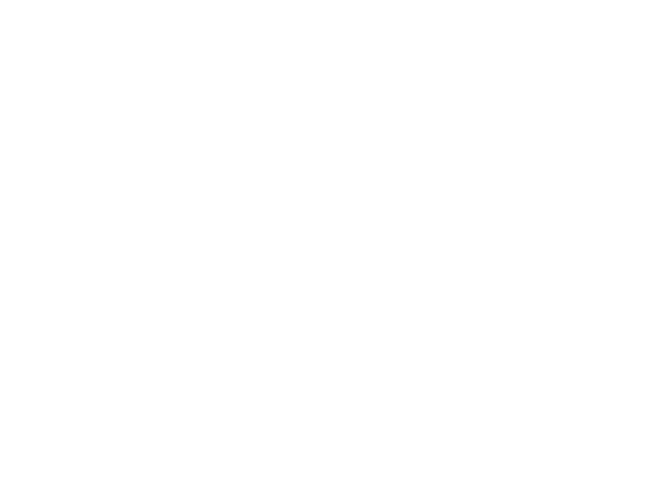

In [360]:
apn = '24945008'
#objectid = 'A_5045'
xmin, ymin, xmax, ymax = sj_parcels.loc[sj_parcels['APN'] == apn].to_crs(
    'EPSG:26910').buffer(100).to_crs('EPSG:4326').total_bounds
sj_parcels_filter = sj_parcels.cx[xmin:xmax, ymin:ymax]
permits_filter = permits_gdf.cx[xmin:xmax, ymin:ymax]

fig, ax = plt.subplots()
sj_parcels_filter.plot(ax=ax, facecolor='none')
sj_parcels.loc[sj_parcels['APN'] == apn].plot(ax=ax)
permits_filter.plot(ax=ax, color='red')
ax.axis('off')
plt.show()

## Batch 2

In [368]:
permits_raw.columns

Index(['OBJECTID', 'FACILITYID', 'INTID', 'ADDRESS', 'APN', 'APPLICANT',
       'CONTRACTOR', 'WORKDESC', 'SUBDESC', 'PERMITAPPROVAL', 'ISSUEDATE',
       'ISSUEDATEUTC', 'FINALDATE', 'FINALDATEUTC', 'DWELLINGUNIT',
       'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM', 'LASTUPDATE', 'LASTEDITOR',
       'NOTES', 'ENTERPRISEID', 'geometry', 'permit_status', 'year'],
      dtype='object')

In [370]:
CF_permits_raw = permits_raw.loc[permits_raw['year'].isin([2015, 2016, 2017, 2018, 2019, 2020])]
CF_permits_raw = CF_permits_raw.loc[CF_permits_raw['APN'].isin(sj_parcels_cbgs['APN'])]

In [377]:
print('Using Permit APNs (i.e. original APNs)')
print('Number of permits: {}'.format(len(CF_permits_raw)))
print('Number of parcels: {}'.format(len(CF_permits_raw['APN'].unique())))

Using Permit APNs (i.e. original APNs)
Number of permits: 3310
Number of parcels: 3068


In [379]:
CF_permits.columns

Index(['OBJECTID_left', 'FACILITYID', 'INTID_left', 'ADDRESS', 'APN',
       'APPLICANT', 'CONTRACTOR', 'WORKDESC', 'SUBDESC', 'PERMITAPPROVAL',
       'ISSUEDATE', 'ISSUEDATEUTC', 'FINALDATE', 'FINALDATEUTC',
       'DWELLINGUNIT', 'PERMITVALUE', 'SQUAREFOOT', 'FOLDERNUM',
       'LASTUPDATE_left', 'LASTEDITOR', 'NOTES_left', 'ENTERPRISEID',
       'geometry_permit', 'permit_status', 'OBJECTID_right', 'PARCELID',
       'INTID_right', 'APN_parcel', 'LOTNUM', 'PARCELTYPE', 'FEATURECLASS',
       'PLANCRT', 'PLANMOD', 'LASTUPDATE_right', 'NOTES_right', 'COVERED',
       'SHAPE_Length', 'SHAPE_Area', 'geometry_parcel', 'issue_date_converted',
       'foldernum_year', 'issue_year'],
      dtype='object')

In [380]:
CF_permits = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])]
CF_permits = CF_permits.loc[CF_permits['APN_parcel'].isin(sj_parcels_cbgs['APN'])]

In [382]:
print('Using Spatially-matched APNs')
print('Number of permits: {}'.format(len(CF_permits)))
print('Number of parcels: {}'.format(len(CF_permits['APN_parcel'].unique())))

Using Spatially-matched APNs
Number of permits: 3176
Number of parcels: 2989
